This notebook investigates predictive models for the aspects part of the review data based on the extracted nouns. The output is therefore multiclass.

* Section 1 - Import libraries and dataset
* Section 2 - Data cleaning
* Section 3 - Data preprocessing
* Section 4 - Building an aspect classifier (accommodation)
* Section 5 - Building an aspect classifier (food)
* Section 6 - Building an aspect classifier (Attractions)
* Section 7 - Data augmentation methods (attractions)
* Section 8 - Data augmentation (accommodation and food)

Dataset needed to run this notebook:

* combinedaspectcheck.xlsx

# Section 1: Import libraries and dataset

In [7]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE
import os
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight
import pickle

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Bring in manually annotated accommodation data from spreadsheet file
df_accom = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDACCOM",engine = "openpyxl")
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD", engine = "openpyxl")
df_attract = pd.read_excel("combinedaspectcheck.xlsx", sheet_name = "CLEANEDATTRACT", engine = "openpyxl")

In [9]:
df_accom.drop(["Category"],axis = 1, inplace = True)
df_food.drop(["Category"],axis = 1,inplace = True)
df_attract.drop(["Category"],axis = 1,inplace = True)

# Section 2: Data Cleaning

## Accommodation

In [10]:
df_accom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigInd       2220 non-null   int64  
 1   Cleaned       2220 non-null   object 
 2   Noun Phrases  2220 non-null   object 
 3   Nouns         2220 non-null   object 
 4   Aspect        2220 non-null   object 
 5   Sentiment     2220 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 104.2+ KB


In [11]:
# Aspect value counts
df_accom["Aspect"].value_counts()

Room             350
Food             350
Staff            350
Hotel            349
Entertainment    348
Value            250
Location         215
location           5
entertainment      2
hotel              1
Name: Aspect, dtype: int64

In [12]:
# Set to title case as some categories are multiples
df_accom["Aspect"] = df_accom["Aspect"].apply(lambda x: x.title())

In [13]:
df_accom["Aspect"].value_counts()

Room             350
Entertainment    350
Food             350
Staff            350
Hotel            350
Value            250
Location         220
Name: Aspect, dtype: int64

Mostly balanced categories, the two smaller categories represent those where all datapoints were used but there were just fewer overall.

## Food

In [14]:
df_food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigInd       2100 non-null   int64  
 1   Cleaned       2100 non-null   object 
 2   Noun Phrases  2100 non-null   object 
 3   Nouns         2100 non-null   object 
 4   Sentiment     2100 non-null   float64
 5   Aspect        2100 non-null   object 
 6   Orig Aspect   2100 non-null   object 
 7   Column1       0 non-null      float64
dtypes: float64(2), int64(1), object(5)
memory usage: 131.4+ KB


In [15]:
# Aspect value counts
df_food["Aspect"].value_counts()

Menu Choice      350
Meal Exp         350
Staff&Service    350
Visit Exp        350
Value            350
Food Quality     350
Name: Aspect, dtype: int64

Balanced aspect categories

## Attractions

In [16]:
df_attract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigInd       1650 non-null   int64  
 1   Cleaned       1650 non-null   object 
 2   Noun Phrases  1650 non-null   object 
 3   Nouns         1650 non-null   object 
 4   Sentiment     1650 non-null   float64
 5   Aspect        1650 non-null   object 
 6   OrigAspect    1648 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 90.4+ KB


In [17]:
# Aspect value counts
df_attract["Aspect"].value_counts()

Nature           300
Amenities        300
Activities       300
VisitExp&Gen     250
Staff&Service    200
History          150
Value            150
Name: Aspect, dtype: int64

Unbalanced aspect categories due to not many datapoints available in the original dataset for some of the categories

# Section 3: Data preprocessing

## Define X and y

In [18]:
# Function to split the data between X and y

def XY(df):
    X = df["Nouns"]
    y = df["Aspect"]

    return X,y

In [19]:
# Apply function and print shape
X_accom,y_accom = XY(df_accom)
X_food,y_food = XY(df_food)
X_attract,y_attract = XY(df_attract)

print(X_accom.shape,y_accom.shape)
print(X_food.shape,y_food.shape)
print(X_attract.shape,y_attract.shape)


(2220,) (2220,)
(2100,) (2100,)
(1650,) (1650,)


## Train test split

In [20]:
# Train, validation, test split
def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.20, shuffle = True, random_state = 1)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, shuffle = True, random_state = 1)
    return X_train,X_val, X_test, y_train,y_val,y_test

In [21]:
# Run function for each category
X_train_accom,X_val_accom,X_test_accom,y_train_accom,y_val_accom,y_test_accom = train_test(X_accom,y_accom)
X_train_food,X_val_food,X_test_food,y_train_food,y_val_food,y_test_food = train_test(X_food,y_food)
X_train_attract,X_val_attract,X_test_attract,y_train_attract,y_val_attract,y_test_attract = train_test(X_attract,y_attract)

In [22]:
# Shape of training, validation and test sets for each category
print(X_train_accom.shape, X_val_accom.shape,X_test_accom.shape, y_train_accom.shape, y_val_accom.shape, y_test_accom.shape)
print(X_train_food.shape, X_val_food.shape,X_test_food.shape, y_train_food.shape, y_val_food.shape, y_test_food.shape)
print(X_train_attract.shape, X_val_attract.shape,X_test_attract.shape, y_train_attract.shape, y_val_attract.shape, y_test_attract.shape)

(1776,) (222,) (222,) (1776,) (222,) (222,)
(1680,) (210,) (210,) (1680,) (210,) (210,)
(1320,) (165,) (165,) (1320,) (165,) (165,)


In [23]:
# Get maximum number of nouns to use in the 'maxlen' arguement
print(pd.DataFrame(X_train_accom)["Nouns"].str.split().apply(len).max())
print(pd.DataFrame(X_train_food)["Nouns"].str.split().apply(len).max())
print(pd.DataFrame(X_train_attract)["Nouns"].str.split().apply(len).max())

10
9
9


## Encode y and X

In [24]:
# Function to encode y values as one-hot encoded for hold-out model

def bin(y_train, y_val, y_test):
    binarizer = preprocessing.LabelBinarizer()
    y_train_e = binarizer.fit_transform(y_train)
    y_val_e = binarizer.transform(y_val)
    y_test_e = binarizer.transform(y_test)
    return y_train_e,y_val_e,y_test_e

In [25]:
# Function to encode y values as integer labels (necessary for stratified cross validation as one-hot encoded doesn't work)

def lab(y_train, y_val, y_test):
    le = preprocessing.LabelEncoder()
    y_train_l = le.fit_transform(y_train)
    y_val_l = le.fit_transform(y_val)
    y_test_l = le.transform(y_test)
    return y_train_l,y_val_l, y_test_l

In [26]:
# Apply function
y_train_accom_e, y_val_accom_e, y_test_accom_e = bin(y_train_accom, y_val_accom, y_test_accom)
y_train_food_e, y_val_food_e, y_test_food_e = bin(y_train_food, y_val_food, y_test_food)
y_train_attract_e, y_val_attract_e, y_test_attract_e = bin(y_train_attract, y_val_attract, y_test_attract)

y_train_accom_l, y_val_accom_l, y_test_accom_l = lab(y_train_accom, y_val_accom, y_test_accom)
y_train_food_l, y_val_food_l, y_test_food_l = lab(y_train_food, y_val_food, y_test_food)
y_train_attract_l, y_val_attract_l, y_test_attract_l = lab(y_train_attract, y_val_attract, y_test_attract)

In [27]:
# Function to fit tokenizer on text and transform to padded word embeddings

def tok(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words = 5000)
    tokenizer.fit_on_texts(X_train)
    X_train_s = tokenizer.texts_to_sequences(X_train)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_test)
    X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"), maxlen = 20, padding = "post", truncating = "post", value = 0.0)
    
    return tokenizer, X_train_w, X_val_w, X_test_w

In [28]:
# Apply function to X training, validation and test sets
accom_tok, X_train_accom_w, X_val_accom_w, X_test_accom_w = tok(X_train_accom, X_val_accom, X_test_accom)
food_tok,X_train_food_w, X_val_food_w, X_test_food_w = tok(X_train_food, X_val_food, X_test_food)
attract_tok,X_train_attract_w, X_val_attract_w, X_test_attract_w = tok(X_train_attract, X_val_attract, X_test_attract)

In [29]:
# Function to save test data and tokenizers as pickle file
def save_tok(name,file):
    with open(name, 'wb') as handle:
        pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)
        

In [30]:
# Save out test sets for use in combined model testing
save_tok('X_test_accom.pickle',X_test_accom_w)
save_tok('X_test_food.pickle',X_test_food_w)
save_tok('X_test_attract.pickle',X_test_attract_w)

save_tok('y_test_accom.pickle',y_test_accom_e)
save_tok('y_test_food.pickle',y_test_food_e)
save_tok('y_test_attract.pickle',y_test_attract_e)

In [31]:
# Save out the tokenizers
save_tok('accom_tokenizer.pickle',accom_tok)
save_tok('food_tokenizer.pickle',food_tok)
save_tok('attract_tokenizer.pickle',attract_tok)

In [32]:
# Shape of y training, validation and test
print(y_train_accom_e.shape, y_val_accom_e.shape, y_test_accom_e.shape)
print(y_train_food_e.shape, y_val_food_e.shape, y_test_food_e.shape)
print(y_train_attract_e.shape, y_val_attract_e.shape, y_test_attract_e.shape)

print(y_train_accom_l.shape, y_val_accom_l.shape, y_test_accom_l.shape)
print(y_train_food_l.shape, y_val_food_l.shape, y_test_food_l.shape)
print(y_train_attract_l.shape,  y_val_attract_l.shape,y_test_attract_l.shape)

(1776, 7) (222, 7) (222, 7)
(1680, 6) (210, 6) (210, 6)
(1320, 7) (165, 7) (165, 7)
(1776,) (222,) (222,)
(1680,) (210,) (210,)
(1320,) (165,) (165,)


In [33]:
#with open('tok_accom.pickle', 'wb') as handle:
    #pickle.dump(tok_accom, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
# Get shape of training, validation and test sets
print(X_train_accom_w.shape,y_train_accom_e.shape)
print(X_train_food_w.shape, y_train_food_e.shape)
print(X_train_attract_w.shape, y_train_attract_e.shape)

(1776, 20) (1776, 7)
(1680, 20) (1680, 6)
(1320, 20) (1320, 7)


## Define general functions used for each model

In [35]:
# Visualise the training and test accuracies and losses

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

In [36]:
# The model will use earlystopping if the valuation loss doesn't decrease after a specified number of epochs

def out(name):
    output_dir = name
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir
        
def call(output_dir,patience):
    modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
    callbacks = [EarlyStopping(monitor = "val_loss", patience = patience),modelcheckpoint]
    return callbacks

In [37]:
# Confusion Matrix function

def class_conf(y_val_integer,y_pred_class,labels):
    classification = classification_report(y_val_integer, y_pred_class)
    fig, ax = plt.subplots(figsize = (8,6))
    cf_matrix = confusion_matrix(y_val_integer, y_pred_class)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",cmap = plt.cm.Blues,labels = labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    print(classification)

In [38]:
# Weight adjustments if required

def weight(y_train):
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    return class_weights

In [39]:
# Combine training and validation sets for use in stratified cross validation

def combine(X_train, X_val, y_train,y_val):
    inputs = np.concatenate((X_train,X_val), axis=0)
    targets = np.concatenate((y_train, y_val), axis=0)
    
    return inputs, targets


In [40]:
# Model with output of 7 classes

def create_model_a():
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length = input_length))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', input_shape=(1600,)))
    model.add(Dropout(rate=0.5))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model
    

In [41]:
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length = input_length))
model.add(Flatten())
model.add(Dense(512, activation='relu', input_shape=(1600,)))
model.add(Dropout(rate=0.5))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

NameError: name 'input_dim' is not defined

In [42]:
# Model with output of 6 classes

def create_model_b():
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length = input_length))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', input_shape=(1600,)))
    model.add(Dropout(rate=0.5))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [43]:
# Stratified KFold function using keras wrapper in scikit learn (Use X_train encoded as word embedding and y_train encoded 
# with labels NOT one-hot encoded)

def cross(X,y,create_model_a):
    model = KerasClassifier(build_fn=create_model_a, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    results = cross_val_score(model, X,y, cv=kfold)
    print(results.mean())

In [44]:
# Function to fit model, print training and validation accuracies

def run_mod(model, X_train, X_val, y_train, y_val):
    val_acc = []
    history = model.fit(X_train, y_train,
                       epochs = epochs,
                       verbose = 2,
                       callbacks = callbacks,
                       validation_data = (X_val, y_val),
                       batch_size = batch_size,
                       class_weight = class_weights)
    print("\n\n")
    print(model.evaluate(X_train, y_train))
    print(model.evaluate(X_val, y_val))
    print("\n\n")
    plot_history(history)


In [45]:
# Evaluation function

def eval(model,output_dir,name,X_val,y_val,y_val_aspect,labels):
    model.load_weights(output_dir+name)
    y_pred_prob = model.predict(X_val)
    y_pred_class = np.argmax(model.predict(X_val), axis=-1)
    y_val_integer = np.argmax(y_val, axis=1)
    df_pred = pd.DataFrame(list(zip(y_val_integer, y_val_aspect,y_pred_class)), columns=["Actual Class", "Actual Aspect","Predicted Class",])
    df_wrong = df_pred[df_pred["Actual Class"]!= df_pred["Predicted Class"]]
    class_conf(y_val_integer,y_pred_class,labels)
    print("\n")
    print("The model predicted:", df_wrong.shape[0],"aspects wrong from a total of:",df_pred.shape[0],"predictions")
    print("\n")
    return df_pred, df_wrong

In [46]:
# Run weights function to get weights

cw_accom = weight(y_accom)
cw_food = weight(y_food)
cw_attract = weight(y_attract)

# Section 4: Building accommodation aspect classifier

In [47]:
# Set parameters

input_dim = 6000 #number of words
output_dim = 16
input_length = 20 #maximum length of embedding
batch_size = 16
epochs = 50

class_weights_accom = {0:cw_accom[0],1:cw_accom[1],2:cw_accom[2],3:cw_accom[3],4:cw_accom[4],5:cw_accom[5],6:cw_accom[6]}
n_splits = 10

# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/AccomAspectModels')
callbacks = call(output_dir,5)
class_weights = class_weights_accom


### Cross validation evaluation

In [48]:
# Combine training and validation sets for word embeddings and target encoded as integers as multi-label indicator (one-hot)
# encoding is not supported
# Run stratified cross validation and report mean accuracy for ten folds using create_model_a with 7 output parameters

X_train_accom_cross, y_train_accom_cross = combine(X_train_accom_w, X_val_accom_w, y_train_accom_l,y_val_accom_l)
cross(X_train_accom_cross, y_train_accom_cross,create_model_a)

0.9234422087669373


### Hold out evaluation

Epoch 1/50
111/111 - 0s - loss: 1.8235 - accuracy: 0.2579 - val_loss: 1.3915 - val_accuracy: 0.5811
Epoch 2/50
111/111 - 0s - loss: 0.8782 - accuracy: 0.6796 - val_loss: 0.6510 - val_accuracy: 0.8063
Epoch 3/50
111/111 - 0s - loss: 0.3877 - accuracy: 0.8930 - val_loss: 0.5461 - val_accuracy: 0.8649
Epoch 4/50
111/111 - 0s - loss: 0.1801 - accuracy: 0.9555 - val_loss: 0.5834 - val_accuracy: 0.8874
Epoch 5/50
111/111 - 0s - loss: 0.0948 - accuracy: 0.9814 - val_loss: 0.5832 - val_accuracy: 0.8739
Epoch 6/50
111/111 - 0s - loss: 0.0646 - accuracy: 0.9859 - val_loss: 0.5538 - val_accuracy: 0.8829
Epoch 7/50
111/111 - 0s - loss: 0.0597 - accuracy: 0.9831 - val_loss: 0.6789 - val_accuracy: 0.8739
Epoch 8/50
111/111 - 0s - loss: 0.0494 - accuracy: 0.9910 - val_loss: 0.5568 - val_accuracy: 0.9009



56/56 [==============================] - 0s 857us/step - loss: 0.0148 - accuracy: 0.9961
[0.014820967800915241, 0.9960585832595825]
7/7 [==============================] - 0s 1ms/step - loss: 0.5568

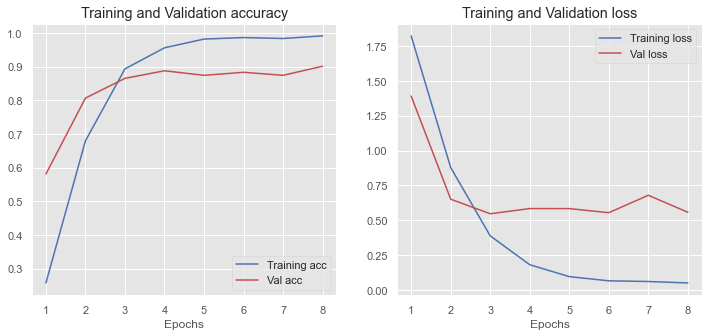

In [49]:
# Run model using the word embeddings and the target encoded as one-hot encoding
model1 = create_model_a()
history1 = run_mod(model1, X_train_accom_w, X_val_accom_w, y_train_accom_e, y_val_accom_e)
model1.save('accommodation.h5')

AttributeError: 'QuadMesh' object has no property 'labels'

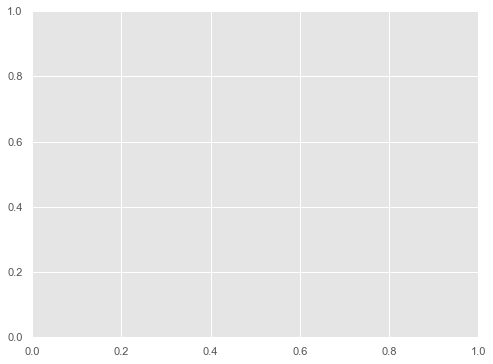

In [50]:
label_accom = ['Entertainment','Food','Hotel','Location','Room','Staff','Value']
df_pred_accom, df_wrong_accom = eval(model1, output_dir,"/weights.04.hdf5",X_val_accom_w, y_val_accom_e,y_val_accom,label_accom)

In [480]:
df_wrong_accom

,Actual Class,Actual Aspect,Predicted Class
0,0,Entertainment,6
2,2,Hotel,6
14,0,Entertainment,1
16,2,Hotel,5
26,2,Hotel,4
33,5,Staff,0
47,4,Room,0
50,5,Staff,0
75,1,Food,5
77,3,Location,0


General comments:

* the model is overfitting
* the model seems to misclassifying some aspects - these topics may be fuzzy fitting into more than one aspect (for example index 19 (entertainment, food, staff)
* more training data might help the model improve classification

# Section 5: Building a food aspect classifier

## Build model

In [468]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 16
epochs = 50
class_weights_food = {0:cw_food[0],1:cw_food[1],2:cw_food[2],3:cw_food[3],4:cw_food[4],5:cw_food[5]}

# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/FoodAspectModels')
callbacks = call(output_dir,5)
class_weights = class_weights_food

### Cross validation evaluation

In [469]:
# Combine training and validation sets for word embeddings and target encoded as integers as multi-label indicator (one-hot)
# encoding is not supported
# Run stratified cross validation and report mean accuracy for ten folds using create_model_a with 6 output parameters

X_train_food_cross, y_train_food_cross = combine(X_train_food_w, X_val_food_w, y_train_food_l,y_val_food_l)
cross(X_train_food_cross, y_train_food_cross,create_model_b)

0.9560846626758576


### Hold-out evaluation

Epoch 1/50
105/105 - 0s - loss: 1.6665 - accuracy: 0.3131 - val_loss: 1.0020 - val_accuracy: 0.7476
Epoch 2/50
105/105 - 0s - loss: 0.5935 - accuracy: 0.7952 - val_loss: 0.1854 - val_accuracy: 0.9571
Epoch 3/50
105/105 - 0s - loss: 0.1714 - accuracy: 0.9524 - val_loss: 0.1654 - val_accuracy: 0.9619
Epoch 4/50
105/105 - 0s - loss: 0.0808 - accuracy: 0.9744 - val_loss: 0.1550 - val_accuracy: 0.9619
Epoch 5/50
105/105 - 0s - loss: 0.0553 - accuracy: 0.9857 - val_loss: 0.1415 - val_accuracy: 0.9619
Epoch 6/50
105/105 - 0s - loss: 0.0531 - accuracy: 0.9863 - val_loss: 0.1929 - val_accuracy: 0.9524
Epoch 7/50
105/105 - 0s - loss: 0.0303 - accuracy: 0.9929 - val_loss: 0.2208 - val_accuracy: 0.9571
Epoch 8/50
105/105 - 0s - loss: 0.0208 - accuracy: 0.9946 - val_loss: 0.2019 - val_accuracy: 0.9524
Epoch 9/50
105/105 - 0s - loss: 0.0242 - accuracy: 0.9952 - val_loss: 0.1768 - val_accuracy: 0.9619
Epoch 10/50
105/105 - 0s - loss: 0.0185 - accuracy: 0.9940 - val_loss: 0.1563 - val_accuracy: 0.9619

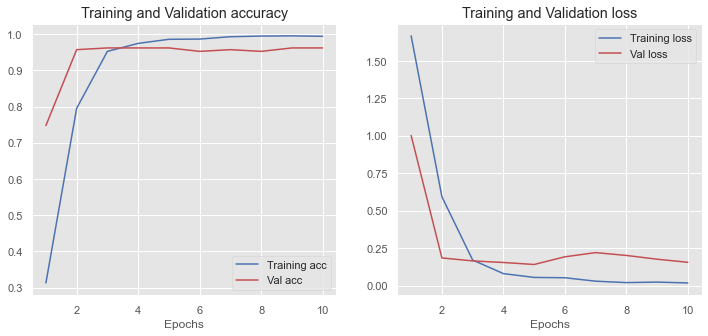

In [470]:
# Run model using the word embeddings and the target encoded as one-hot encoding
model2 = create_model_b()
history2 = run_mod(model2, X_train_food_w, X_val_food_w, y_train_food_e, y_val_food_e)
model2.save('food.h5')

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        35
           1       0.92      0.94      0.93        35
           2       1.00      1.00      1.00        35
           3       1.00      0.97      0.99        35
           4       1.00      0.97      0.99        35
           5       0.94      0.91      0.93        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



The model predicted: 8 aspects wrong from a total of: 210 predictions




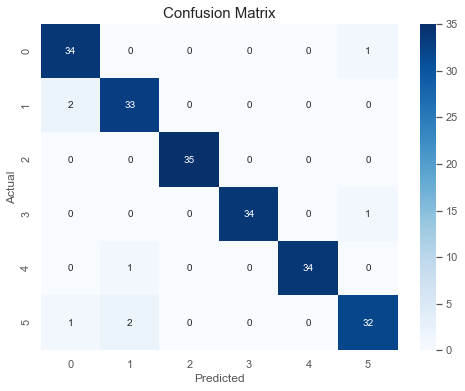

In [471]:
df_wrong_food = eval(model2, output_dir,"/weights.03.hdf5",X_val_food_w, y_val_food_e,y_val_food)

Visit experience is predicted as meal experience suggesting these aspects are a bit fuzzy. Therefore combining them may improve the model.

In [472]:
# Combine the categories and sample to 350 as per other aspects
df_food_revised = df_food.copy()
df_food_revised["Aspect"] = df_food_revised["Aspect"].replace("Visit Exp","Meal Exp")
df_food_revised = df_food_revised.groupby('Aspect').sample(n = 350)
df_food_revised["Aspect"].value_counts()

Menu Choice      350
Value            350
Meal Exp         350
Food Quality     350
Staff&Service    350
Name: Aspect, dtype: int64

In [473]:
X_food,y_food = XY(df_food_revised)
print(X_food.shape, y_food.shape)

(1750,) (1750,)


In [476]:
# Get train, val, test, encode y as labels and one-hot encoding and X as word embeddings
X_train_food,X_val_food,X_test_food,y_train_food,y_val_food,y_test_food = train_test(X_food,y_food)
y_train_food_e, y_val_food_e, y_test_food_e = bin(y_train_food, y_val_food, y_test_food)
y_train_food_l, y_val_food_l, y_test_food_l = lab(y_train_food, y_val_food, y_test_food)
food_tok,X_train_food_w, X_val_food_w, X_test_food_w = tok(X_train_food, X_val_food, X_test_food)

In [477]:
# Save out new test sets and tokenizer for use in combined model testing
save_tok('X_test_food.pickle',X_test_food_w)
save_tok('y_test_food.pickle',y_test_food_e)
save_tok('food_tokenizer.pickle',food_tok)

In [ ]:
# Redefine model with output of 5
def create_model_c():
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length = input_length))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', input_shape=(1600,)))
    model.add(Dropout(rate=0.5))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [ ]:
# Run cross validation
X_train_food_cross2, y_train_food_cross2 = combine(X_train_food_w, X_val_food_w, y_train_food_l,y_val_food_l)
cross(X_train_food_cross2, y_train_food_cross2,create_model_c)

In [ ]:
# Run model using the word embeddings and the target encoded as one-hot encoding
model2b = create_model_c()
history2b = run_mod(model2b, X_train_food_w, X_val_food_w, y_train_food_e, y_val_food_e)
model2b.save('food.h5')

In [ ]:
df_wrong_food2 = eval(model2b, output_dir,"/weights.07.hdf5",X_val_food_w, y_val_food_e,y_val_food)

Analysis:

* Combining the aspects of Meal and Visit experience helped improve model accuracy considerably

# Section 6: Building an attractions model

## Build a model

In [ ]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 16
epochs = 50
class_weights_attract = {0:cw_attract[0],1:cw_attract[1],2:cw_attract[2],3:cw_attract[3],4:cw_attract[4],5:cw_attract[5],6:cw_attract[6]}

output_dir = out('model_output/AtractAspectModels')
callbacks = call(output_dir,5)
class_weights = class_weights_attract

### Cross validation  evaluation

In [ ]:
# Combine training and validation sets for word embeddings and target encoded as integers as multi-label indicator (one-hot)
# encoding is not supported
# Run stratified cross validation and report mean accuracy for ten folds using create_model_a with 7 output parameters

X_train_attract_cross, y_train_attract_cross = combine(X_train_attract_w, X_val_attract_w, y_train_attract_l,y_val_attract_l)
cross(X_train_attract_cross, y_train_attract_cross,create_model_a)

In [ ]:
# Run model using the word embeddings and the target encoded as one-hot encoding
model3 = create_model_a()
run_mod(model3, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)
model3.save('attract.h5')

In [ ]:
df_wrong_attract = eval(model3, output_dir,"/weights.08.hdf5",X_val_attract_w, y_val_attract_e,y_val_attract)

In [ ]:
df_wrong_attract.head()

Analysis of results:

* The food model performs best, possibly because the word range is much smaller and the aspects contain fewer words.
* Combining the Visit Experience and Meal Experience categories improved the model a little.
* The accommodation and attraction models are less accurate possibly because the range of words is greater and there is more scope for classification errors to be made. Increased training data might improve the results for these categories.
* Data augmentation is used to increase the training set size for the attractions model which is the worst performing of the three with a cross validation accuracy of 85%

# Section 6: Data Augmentation - Attractions

Augment the training data using a range of techniques such as changing, deleting, swapping words to increase the number of training samples with synthetic data based on the actual data. Whether to augment the validation set as well as the training set is a bone of contention.

https://stats.stackexchange.com/questions/320800/data-augmentation-on-training-set-only/320967#320967

On the one hand augmenting just the training is done to reduce overfitting and improve generalisation but if the augmentation is introducing samples which are different and therefore make the training set not representative, it will not perform well when it sees the validation set which does not contain the augmented samples. Some argue that the validation set should be taken from the augmented data to get a proper comparison. Performance on the validation set helps to determine which model to use. 

Based on reading the opinions from links such as above, a decision was taken to follow the usual practice of only augmenting the training data.

Cross validation is difficult here as the folds result in augmented data leaking into the test portion so instead the models are run ten times and an average accuracy taken based on that.

In [ ]:
# Concat and shuffle the training data
attract_eda = pd.concat([X_train_attract,y_train_attract],axis = 1)
attract_eda = attract_eda.sample(frac=1)
attract_eda.head()

In [ ]:
attract_eda.shape

In [ ]:
# Get number of words in each row, split dataframes into those with more than 1 word and those with 1
attract_eda["Count"] = attract_eda["Nouns"].apply(lambda x: len(x.split()))
attract_eda["Count"].value_counts()

Most lines have just one word and those with more than one word have mostly two - this will inform the augmentation process

## Functions

In [ ]:
# Functions to run various data augmentation functions separately on the original dataframe

def aug(df):
    
    insertion = pd.DataFrame(df["Nouns"].apply(lambda x: t.random_insertion(x, n = 1)))
    insertion = pd.concat([insertion,df.Aspect],axis = 1)
    insertion = insertion.append(df)
 
    replaced = pd.DataFrame(df["Nouns"].apply(lambda x: t.synonym_replacement(x, n = 1)))
    replaced = pd.concat([replaced,df.Aspect],axis = 1)
    replaced = replaced.append(df)

    swapped = pd.DataFrame(df["Nouns"].apply(lambda x: t.random_swap(x,n  = 1)))
    swapped = pd.concat([swapped,df.Aspect],axis = 1)
    swapped = swapped.append(df)

    swapped["Count"] = swapped["Nouns"].apply(lambda x: len(x.split()))
    equal_one = swapped[swapped["Count"]==1].reset_index()
    more_one = swapped[swapped["Count"]>1].reset_index()

    deleted = pd.DataFrame(more_one["Nouns"].apply(lambda x: t.random_deletion(x,p = 0.2)))
    deleted = pd.concat([deleted,more_one.Aspect],axis = 1,ignore_index=True)
    deleted.columns = ["Nouns","Aspect"]

    equal_one.drop(columns = "Count",axis = 1, inplace = True)
    equal_one = equal_one.set_index("index")
    deleted = deleted.append(equal_one)
    #deleted = deleted.append(df)
   
    return insertion, replaced, swapped, deleted

In [ ]:
# Function to create the training set based on the new augmented dataset and then tokenize and binarize the validation and test sets
# based on these new training sets.

def proc_aug(df, X_val, y_val, X_test, y_test):
    
    # Set new X_train and y_train
    X_train2 = df["Nouns"]
    y_train2 = df["Aspect"]

    # Encode new X_train, old X_val and old X_test
    tokenizer = Tokenizer(num_words = 10000)
    tokenizer.fit_on_texts(X_train2)
    X_train_s = tokenizer.texts_to_sequences(X_train2)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_attract)
    X_train_w = pad_sequences(np.array(X_train_s, dtype = "object"),maxlen = 20, padding = "post",truncating = "post", value = 0.0)
    X_val_w = pad_sequences(np.array(X_val_s, dtype = "object"),maxlen = 20, padding = "post",truncating = "post", value = 0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"),maxlen = 20, padding = "post",truncating = "post", value = 0.0)

    # Encode new y_train and old y_val and old y_test
    binarizer = preprocessing.LabelBinarizer()
    y_train_e = binarizer.fit_transform(y_train2)
    y_val_e = binarizer.fit_transform(y_val)
    y_test_e = binarizer.fit_transform(y_test)
            
    return X_train_w, y_train_e, X_val_w, y_val_e, X_test_w, y_test_e

In [ ]:
# Define parameters - increase the input dim to match the tokenizer above

input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 16
epochs = 50
class_weights_attract = {0:cw_attract[0],1:cw_attract[1],2:cw_attract[2],3:cw_attract[3],4:cw_attract[4],5:cw_attract[5],6:cw_attract[6]}
class_weights = class_weights_attract

output_dir = out('model_output/AttractAspectModelsAug1')
callbacks = call(output_dir,5)

## Random insertion

In [ ]:
# Import easy data augmentation package and set test sentence

from textaugment import EDA
t = EDA()

test = "tasty food service"
test

In [ ]:
# Random insertion one word
t.random_insertion(test, n = 1)

In [ ]:
# Run  augmentation function on the accommodation data
insertion, replaced, swapped, deleted = aug(attract_eda)
print(insertion.shape, replaced.shape, swapped.shape, deleted.shape)

In [ ]:
# Run encoding function on the augmented data and the original validation and test data
X_train_attract_w, y_train_attract_e, X_val_attract_w, y_val_attract_e, X_test_attract_w, y_test_attract_e = proc_aug(insertion, X_val_attract, y_val_attract, X_test_attract, y_val_attract)

In [ ]:
# Run model using the word embeddings and the target encoded as one-hot encoding
model_attract_insert = create_model_a()
run_mod(model_attract_insert, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

In [ ]:
# Run model through ten times and get the average validation accuracy and training accuracy

def evaluation(model, X_train, X_val, y_train, y_val):
    train_acc = []
    val_acc = []
    for i in range(1,11):
        history = model.fit(X_train, y_train,epochs = epochs,verbose = 0,callbacks = callbacks,validation_data = (X_val, y_val),
                            batch_size = batch_size,class_weight = class_weights)
        train_acc.append(model.evaluate(X_train, y_train)[1])
        val_acc.append(model.evaluate(X_val, y_val)[1])
        train_acc_mean = sum(train_acc)/10
        val_acc_mean = sum(val_acc)/10
        
    return train_acc_mean,val_acc_mean
    

In [ ]:
evaluation(model_attract_insert, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

###  Synonym replacement

In [ ]:
# Run synonym replacement
t.synonym_replacement(test,n = 1)

In [ ]:
# Run  augmentation and encoding function on the accommodation data
output_dir = out('model_output/AttractAspectModelsAug2')
X_train_attract_w, y_train_attract_e, X_val_attract_w, y_val_attract_e, X_test_attract_w, y_test_attract_e = proc_aug(replaced, X_val_attract, y_val_attract, X_test_attract, y_val_attract)
model_attract_replace = create_model_a()
history_attract_replace = run_mod(model_attract_replace, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

In [ ]:
evaluation(model_attract_replace, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

### Random swap

Randomly swap two words in the augmented text

In [ ]:
# Randomly swap words in the sentence 
t.random_swap(test, n = 1)

In [ ]:
# Run  augmentation and encoding function on the accommodation data
output_dir = out('model_output/AttractAspectModelsAug3')
X_train_attract_w, y_train_attract_e, X_val_attract_w, y_val_attract_e, X_test_attract_w, y_test_attract_e = proc_aug(swapped, X_val_attract, y_val_attract, X_test_attract, y_val_attract)
model_attract_swap = create_model_a()
history_attract_swap = run_mod(model_attract_swap, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

In [ ]:
evaluation(model_attract_swap, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

## Random deletion

Randomly delete words with a certain probability

In [ ]:
# Delete a random word in the sentence with a probability of 0.2 
t.random_deletion(test, p=0.2)

In [ ]:
# Run  augmentation and encoding function on the accommodation data
output_dir = out('model_output/AttractAspectModelsAug4')
X_train_attract_w, y_train_attract_e, X_val_attract_w, y_val_attract_e, X_test_attract_w, y_test_attract_e = proc_aug(deleted, X_val_attract, y_val_attract, X_test_attract, y_val_attract)
model_attract_delete = create_model_a()
history_attract_del = run_mod(model_attract_delete, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

In [ ]:
evaluation(model_attract_delete, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

* Random insertion and synonym replacement seem to work the best of the augmented methods
* The best accuracies occurred in both of these models suggesting that either might work
* Random insertion is the quickest to run on the base dataset

# Section 10: Best attractions model

In [ ]:
output_dir = out('model_output/AttractAspectModelsAug1')
df_wrong_attract_best = eval(model_attract_insert, output_dir,"/weights.07.hdf5",X_val_attract_w, y_val_attract_e,y_val_attract)